In [1]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import random
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
import datasets
import matplotlib.pyplot as plt
# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()
import nltk
nltk.download('punkt')

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

c:\Users\asger\AppData\Local\pypoetry\Cache\virtualenvs\advanced_social_data-1nT6mJ2B-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exercise: RNNs

In this exercise session, you will be building on your knowledge from the previous session to define and train an RNN in PyTorch. This will be a many-to-one RNN, which takes in tweets as seuqences of words and outputs a classification of the tweet as negative, neutral or positive. First, we will load the `tweet_eval` dataset, convert the words into the tweets into embeddings (more on this below) and turn it into a Torch dataset. Next, we will set up the RNN. Then, we will train and evaluate our network on the data. Finally, we will explore alternatives to simple RNNs: LSTMs, bidirectional RNNs, and deep RNNs.

We will provide you with code snippets to help you get started. Where you see a `FILLINTHEBLANK` in the code, or a line that ends in a `=`, that is where you complete the code to make it functional.

Note: in order to see the embedding matrix figure included in Problem 2, you need to download the file `embedding_matrix.png` from Absalon and store it in the same folder as this notebook.

# 1. Finish the shallow neural nets exercise.

If you haven't finished the previous exercise set (softmax regression with TF-IDF vectors as a neural net), please finish these before continuing with the RNN exercise. Refer to the previous exercise and solutions notebooks as needed. You don't need to have finished the final, optional step in the previous problem set ("a taste of deep neural networks") in order to start this problem set, but if you finish early with the current problem set, then you can return to that.

# 2. Prepare the tweet_eval dataset

1. Load the train and validation data with the huggingface data loader. If your computer is struggling, use a subset of the training data.
2. Build a full list of the vocabulary (all possible tokens) in the training and validation data. As you see in the skeleton code below, we add an extra empty token "" at the beginning of the dictionary. This is because we ultimately want all inputs (tweets in this case) to be the same length (have the same word count). To do that, we will later "pad" each tweet at the beginning with this padding token, until it is as long as the longest tweet. E.g. if the longest tweet were 10 words, we would tokenize a tweet saying "the cat is on the mat" as: "", "", "", "", "the", "cat", is", "on", "the", "mat".

In [2]:
# load the 3-class sentiment classification data from tweet_eval
# Loading traing and validation data 
train = datasets.load_dataset('tweet_eval', 'sentiment', split='train')
val = datasets.load_dataset('tweet_eval', 'sentiment', split='validation')

train_corpus = [x["text"] for x in train] # Samler alle dokumenterne i en
train_labels = [x["label"] for x in train] # Samler alle deres rigtige klassificeringer'

val_corpus = [x["text"] for x in val]
val_labels = [x["label"] for x in val]

In [3]:
# creating the full list of vocabulary in the tweet_eval data
total_vocabulary = set()
for tweet in train_corpus + val_corpus:
    tokens = word_tokenize(tweet)
    for x in tokens:
        total_vocabulary.add(x.lower())

total_vocabulary = sorted(list(total_vocabulary))

# appending an empty padding token at the beginning of the vocabulary
total_vocabulary = [""]+total_vocabulary

len(total_vocabulary)

53084

3. In this exercise, instead of using TF-IDF as input, we will use all the words of the tweets in their original order. The way we will feed these words into the RNN in the form of numbers is by "embedding" them first. We will talk much more about embeddings later, but what you need to know right now is that embeddings translate tokens like "dog" into vectors (lists of numbers) that capture the underlying meanings of the words. We will use pre-trained embeddings, which means that the way to convert words to vectors was learned by another model on another data set (in this case, still a Twitter data set).

In practice, we do this by giving the model a so-called embedding matrix, with one row per vocabulary word, where the row is the vector that embeds the meaning of that word (see figure below). The code below builds an embedding matrix given a vocabulary using the Gensim library's `glove-twitter-200` downloadable embedding (or `glove-twitter-25` if you find your computer is struggling). It also gives an all-zero embedding to the padding token. Finally, since we are using pre-trained embeddings we might have words in our data that are not present in the embedding. These are called out-of-vocabulary (oov) words, and we will assign an all-zero embedding to those as well.

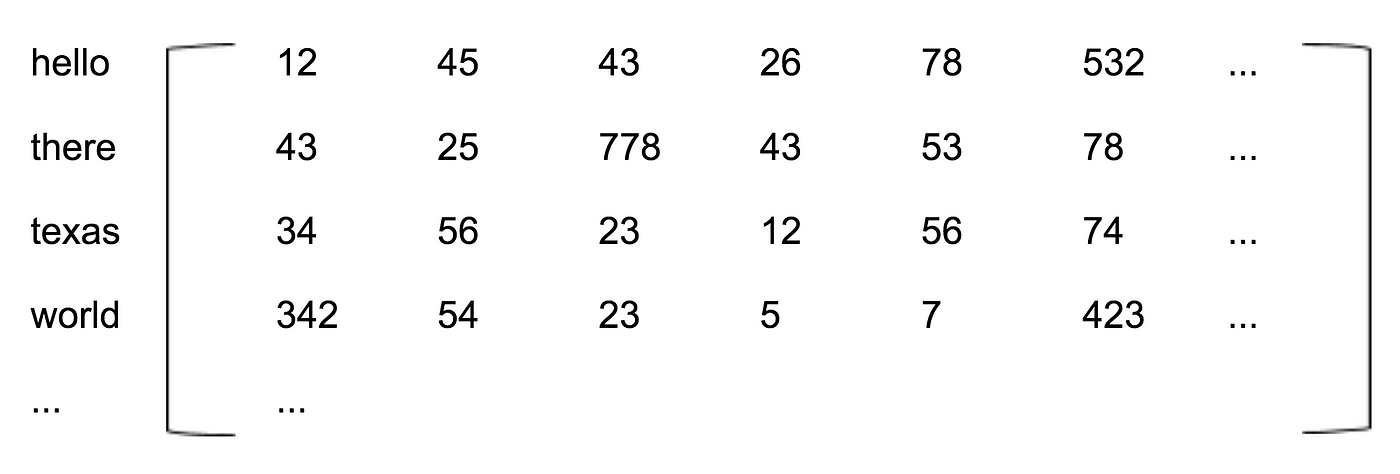

In [4]:

def create_embedding_matrix(tokens, embedding):
    """creates an embedding matrix from pre-trained embeddings for a new vocabulary. It also adds an extra vector
    vector of zeroes in row 0 to embed the padding token, and initializes missing tokens as vectors of 0s"""
    oov = set()
    size = embedding.vector_size
    # note the extra zero vector that will used for padding
    embedding_matrix=np.zeros((len(tokens),size))
    c = 0
    for i in range(1,len(tokens)):
        try:
            embedding_matrix[i]=embedding[tokens[i]]
        except KeyError: #to catch the words missing in the embeddings
            try:
                embedding_matrix[i]=embedding[tokens[i].lower()]
            except KeyError:
                #if the token does not have an embedding, we initialize it as a vector of 0s
                embedding_matrix[i] = np.zeros(size)
                #we keep track of the out of vocabulary tokens
                oov.add(tokens[i])
                c +=1
    print(f'{c/len(tokens)*100} % of tokens are out of vocabulary')
    return embedding_matrix, oov

# load the pretrained embeddings (these can be used as the embedding argument in create_embedding_matrix)
glove = gensim.downloader.load('glove-twitter-200')
#get the embedding matrix and out of vocabulary words for our tweet_eval vocabulary
embedding_matrix, oov = create_embedding_matrix(total_vocabulary, glove)

35.67176550372994 % of tokens are out of vocabulary



4. Convert the tweets to vectors of indices showing which words they contain (these indices will also correspond to the rows of those words in the embedding matrix), including their padding. For example, "the cat is on the mat" could be represented as: [ 0, 0, 0, 0, 5, 1, 2, 4, 5, 3], if those were the positions that corresponded to those words in our dictionary.


In [5]:
# you do not need to modify this code block; simply read through the comments, so you understand what it does, and then run it

def text_to_indices(text, total_vocabulary):
    """turns the input text (one tweet) into a vector of indices in total_vocabulary that corresponds to the tokenized words in the input text"""
    encoded_text = []
    tokens = word_tokenize(text)
    for t in tokens:
        index = total_vocabulary.index(t.lower())
        encoded_text.append(index)
    return encoded_text

def add_padding(vector, max_length, padding_index):
    """adds copies of the padding token to make the input vector the max_length size, so that all inputs are the same length
    (the length of tweet with most words)"""
    if len(vector) < max_length:
        vector = [padding_index for _ in range(max_length-len(vector))] + vector
    return vector

In [6]:
# getting the list of feature vectors by applying the text_to_indices function to each
# tweet in the train and validation corpus
train_features = [text_to_indices(x, total_vocabulary) for x in train_corpus]
val_features = [text_to_indices(x, total_vocabulary) for x in val_corpus]

longest_tweet = max(train_features+val_features, key=len)
max_length = len(longest_tweet)
padding_index = 0 #position 0 is where we had put the padding token in our vocabulary and embedding matrix



In [7]:
# padding the feature vectors in the list by applying the add_padding function to each
# tweet feature vector in the train and validation corpus
train_features = [add_padding(x, max_length, padding_index) for x in train_features]
val_features = [add_padding(x, max_length, padding_index) for x in val_features]

5. Pass the training and validation data to our custom PyTorch DataSet class, and pass that to a data loader. 

In [8]:
class TweetEvalTrain(torch.utils.data.Dataset):
    # defining the sources of the data
    def __init__(self, features, labels):
        self.X = torch.LongTensor(features)
        self.y = torch.from_numpy(np.array(labels)).type(torch.LongTensor) # DET HER ER NOGET, SOM ER TILFØJET SENERE

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index].unsqueeze(0)
        return X, y

    def __len__(self):
        return len(self.y)

data_train = TweetEvalTrain(train_features, train_labels)
data_val = TweetEvalTrain(val_features, val_labels)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 64)

# 2. Define and train the RNN model

1. Use the skeleton code below to create an RNN model with pre-trained embedding layer. The embedding layer should be followed by a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layer, which in its turn is followed by a linear layer. In the forward pass, the model should encode the input (turn it into embeddings), retrieve the final activation state from the last RNN unit. The activation of the final unit in an RNN will (hopefully) encode all relevant info about the whole sequence.



In [9]:
len(embedding_matrix[1])

200

In [10]:
# defining the embedding step and RNN model

class SimpleRNN(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix):
        # initialize the model with a certain dimension of the RNN unit activations (this is rnn_size)
        # and a certain number of output classes
        
        super().__init__()
        
        #applying the embeddings to the inputs
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
        emb_dim = embedding_matrix.shape[1] #this will be the size of the input for the RNN
        
        #define the RNN itself 
        self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, batch_first=True, num_layers=1) #set batch_first=True for your RNN layer
        
        #define the output layer (no softmax needed here; we will apply softmax as part of the loss calculation)
        #applies a linear transformation to the RNN
        #final layer state and outputs scores for the n classes
        self.outputs = torch.nn.Linear(rnn_size, n_classes)

        
    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)
        
        # The RNN returns two tensors: one representing the hidden states at all positions,
        # and another representing only the final hidden states.
        # In this many-to-one model, we only need the final hidden states.
        all_states, final_state = self.rnn(encoded_inputs)
        final_state = final_state.squeeze() #flatten to make sure it has the right dimensions for the next linear step
        
        # run the final state through the output layer
        outputs = self.outputs(final_state)
        return outputs


2. Instatiate a version of the model with `rnn_size=100` and inspect it to see its layers and dimensions. 
3. Try training the model with the same Adam gradient descent optimizer and CrossEntropyLoss as in the previous problem set, training for 3 epochs. Then evaluate its accuracy.

`Note`. We did not use the softmax layer in the forward function. This is because CrossEntropyLoss applies softmax automatically and therefore the function expects the unnormalized probabilities from the final linear layer. That means, however, that your evaluate function needs to use the softmax function on the outputs of your model when predicting. The following snippet might be helpful for evaluation

torch.softmax(model(inputs), 1)

In [11]:
model = SimpleRNN(rnn_size=100, n_classes= 3, embedding_matrix=embedding_matrix)

loss_function = torch.nn.CrossEntropyLoss() # loss function for tracing loss during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer to update weights and biases based on the loss_function
# In summary, the loss function measures the discrepancy between the model's predictions and the ground truth labels, 
# while the optimizer adjusts the model's parameters based on the computed gradients of the loss function 
# in order to minimize the loss and improve the model's performance during training.

model

SimpleRNN(
  (embedding): Embedding(53084, 200, padding_idx=0)
  (rnn): RNN(200, 100, batch_first=True)
  (outputs): Linear(in_features=100, out_features=3, bias=True)
)

In [12]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:

for epoch in range(20):
    losses = [] # storing the loss values for this epoch
    for batch_index, (inputs, targets) in enumerate(train_loader):

        # zero the gradients that are stored from the previous optimization step
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()# compute the outputs of the model
        targets = targets.squeeze() # Converting targets as required for loss function
        
        # compute the loss here
        loss = loss_function(outputs,targets)

        # back-propagate
        loss.backward()

        # perform the optimization step
        optimizer.step()
        
        #add this batch's loss to the losses for this epoch
        losses.append(loss.item())
        
    print(f'Epoch {epoch}: loss {np.mean(losses)}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients for validation, saves memory and computations
        predictions = []
        actuals = []
        for inputs, targets in val_loader:
            outputs = torch.softmax(model(inputs), 1 ) # compute the outputs of the model
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy().tolist())
            actuals.extend(targets.cpu().numpy().tolist())

        accuracy = accuracy_score(actuals, predictions)


    print(f'Epoch {epoch}: loss {np.mean(losses)}, accuracy {accuracy}')
    model.train() # set the model back to training mode

Epoch 0: loss 0.890892523786296
Epoch 0: loss 0.890892523786296, accuracy 0.613
Epoch 1: loss 0.8568070833512476
Epoch 1: loss 0.8568070833512476, accuracy 0.6
Epoch 2: loss 0.8717554365434954
Epoch 2: loss 0.8717554365434954, accuracy 0.567
Epoch 3: loss 0.8410191989045324
Epoch 3: loss 0.8410191989045324, accuracy 0.605
Epoch 4: loss 0.9365829929897528
Epoch 4: loss 0.9365829929897528, accuracy 0.52
Epoch 5: loss 0.906915442890071
Epoch 5: loss 0.906915442890071, accuracy 0.576
Epoch 6: loss 0.8471058892167133
Epoch 6: loss 0.8471058892167133, accuracy 0.611
Epoch 7: loss 0.8095734186292864
Epoch 7: loss 0.8095734186292864, accuracy 0.614
Epoch 8: loss 0.7935871194321845
Epoch 8: loss 0.7935871194321845, accuracy 0.6265
Epoch 9: loss 0.7790337239207927
Epoch 9: loss 0.7790337239207927, accuracy 0.6135
Epoch 10: loss 0.7830574347795645
Epoch 10: loss 0.7830574347795645, accuracy 0.614
Epoch 11: loss 0.8151747709738423
Epoch 11: loss 0.8151747709738423, accuracy 0.6155
Epoch 12: loss 0

# 3. Other types of RNNs

1. Implement a `type` parameter for the model which will control the type of RNN cell used: [vanilla RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). Note that the output from LSTM cells is different from RNN cells, and we need to adjust our output handling in the forward pass accordingly. Try training the LSTM version of the model for 3 epochs, and compare its accuracy to the RNN version.


In [14]:
# advanced version supporting multiple types of RNN layers

class RNN_or_LSTM(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix, type="RNN"):
        # initialize the model with a certain dimension of the RNN unit activations (this is rnn_size)
        # and a certain number of output classes
        super().__init__()
        
        #applying the embeddings to the inputs
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
        
        emb_dim = embedding_matrix.shape[1]
        
        #remember the batch_first=True argument
        if type == "RNN":
            self.rnn =  torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, batch_first=True, num_layers=1)
        elif type == "LSTM":
            self.rnn = torch.nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=False, num_layers=1, batch_first=True)
        #   Here bidirectional= False (hvilken vej det er data bevæger sig)
        else:
            raise LookupError("Only RNN and LSTM are supported.")
        self.output = torch.nn.Linear(rnn_size, n_classes)

    def forward(self, inputs):
        
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)

        #apply the RNN or LSTM
        if type == "RNN":
            all_states, final_state = self.rnn(encoded_inputs)
        else:
            # LSTM's output is different and needs to be treated differently, see documentation for details
            all_states, (final_state, c_n) = self.rnn(encoded_inputs)
        
        # run the final states through the output layer
        outputs = self.output(final_state.squeeze())
        return outputs

In [15]:
model = RNN_or_LSTM(rnn_size=100, n_classes= 3, embedding_matrix=embedding_matrix, type="LSTM")

loss_function = torch.nn.CrossEntropyLoss() # loss function for tracing loss during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer to update weights and biases based on the loss_function
# In summary, the loss function measures the discrepancy between the model's predictions and the ground truth labels, 
# while the optimizer adjusts the model's parameters based on the computed gradients of the loss function 
# in order to minimize the loss and improve the model's performance during training.

model

RNN_or_LSTM(
  (embedding): Embedding(53084, 200, padding_idx=0)
  (rnn): LSTM(200, 100, batch_first=True)
  (output): Linear(in_features=100, out_features=3, bias=True)
)

In [16]:
for epoch in range(10):
    losses = [] # storing the loss values for this epoch
    for batch_index, (inputs, targets) in enumerate(train_loader):

        # zero the gradients that are stored from the previous optimization step
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()# compute the outputs of the model
        targets = targets.squeeze() # Converting targets as required for loss function
        
        # compute the loss here
        loss = loss_function(outputs,targets)

        # back-propagate
        loss.backward()

        # perform the optimization step
        optimizer.step()
        
        #add this batch's loss to the losses for this epoch
        losses.append(loss.item())
        
    print(f'Epoch {epoch}: loss {np.mean(losses)}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients for validation, saves memory and computations
        predictions = []
        actuals = []
        for inputs, targets in val_loader:
            outputs = torch.softmax(model(inputs), 1 ) # compute the outputs of the model
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy().tolist())
            actuals.extend(targets.cpu().numpy().tolist())

        accuracy = accuracy_score(actuals, predictions)


    print(f'Epoch {epoch}: loss {np.mean(losses)}, accuracy {accuracy}')
    model.train() # set the model back to training mode

Epoch 0: loss 0.8011946380556382
Epoch 0: loss 0.8011946380556382, accuracy 0.6655
Epoch 1: loss 0.7089524298362946
Epoch 1: loss 0.7089524298362946, accuracy 0.6855
Epoch 2: loss 0.673364472255466
Epoch 2: loss 0.673364472255466, accuracy 0.693
Epoch 3: loss 0.6416533076913628
Epoch 3: loss 0.6416533076913628, accuracy 0.691
Epoch 4: loss 0.6085347381497499
Epoch 4: loss 0.6085347381497499, accuracy 0.689
Epoch 5: loss 0.5730638567144039
Epoch 5: loss 0.5730638567144039, accuracy 0.687
Epoch 6: loss 0.5347153969516594
Epoch 6: loss 0.5347153969516594, accuracy 0.681
Epoch 7: loss 0.49221503128510535
Epoch 7: loss 0.49221503128510535, accuracy 0.6715
Epoch 8: loss 0.448277255136201
Epoch 8: loss 0.448277255136201, accuracy 0.662
Epoch 9: loss 0.40436695875576467
Epoch 9: loss 0.40436695875576467, accuracy 0.6475



2. Also implement a bidirectional RNN instead of a standard, one-direction RNN. You will have to concatenate the final state of the left-to-right RNN with that of the right-to-left RNN, and feed that into your output layer. Use the code snippet below in your model definition to help you use right parts of the final state tensors. Also that your linear layer has the correct input size--its inputs are now twice the size of the RNN unit activations, because it is getting activations from two different RNNs. Train and evaluate this model as before.

Note: you will see that the bidirectional RNN does not get us better performance. This has something to do with the way we are front-padding the tweets (to equalize their length), combined with the fact that the BRNN goes through the tweets in reverse, so right to left. Thinking of the vanishing gradient problem, can you guess why the second, reverse RNN does not help us in this case?

In [34]:
class Bidirectional_RNN(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix):
        super().__init__()

        #applying the embeddings to the inputs
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
        emb_dim = embedding_matrix.shape[1] #this will be the size of the input for the RNN
        
        #define the RNN itself 
        self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, batch_first=True, num_layers=1, bidirectional=True) #set batch_first=True for your RNN layer
        
        #define the output layer (no softmax needed here; we will apply softmax as part of the loss calculation)
        #applies a linear transformation to the RNN
        #final layer state and outputs scores for the n classes
        self.outputs = torch.nn.Linear(2*rnn_size, n_classes)
    
    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)
        
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        # Notice that we use torch.concat to concatenate the final states from the forward and backward directions
        all_states, final_state = self.rnn(encoded_inputs)
        final_states_combined = torch.cat([final_state[-2,:,:], final_state[-1,:,:]], dim=1)
        
        # run the final state through the output layer
        outputs = self.outputs(final_states_combined)
        return outputs

In [35]:
model = Bidirectional_RNN(rnn_size=100, n_classes= 3, embedding_matrix=embedding_matrix)

loss_function = torch.nn.CrossEntropyLoss() # loss function for tracing loss during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer to update weights and biases based on the loss_function
# In summary, the loss function measures the discrepancy between the model's predictions and the ground truth labels, 
# while the optimizer adjusts the model's parameters based on the computed gradients of the loss function 
# in order to minimize the loss and improve the model's performance during training.

model

Bidirectional_RNN(
  (embedding): Embedding(53084, 200, padding_idx=0)
  (rnn): RNN(200, 100, batch_first=True, bidirectional=True)
  (outputs): Linear(in_features=200, out_features=3, bias=True)
)

In [36]:
for epoch in range(3):
    losses = [] # storing the loss values for this epoch
    for batch_index, (inputs, targets) in enumerate(train_loader):

        # zero the gradients that are stored from the previous optimization step
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()# compute the outputs of the model
        targets = targets.squeeze() # Converting targets as required for loss function
        
        # compute the loss here
        loss = loss_function(outputs,targets)

        # back-propagate
        loss.backward()

        # perform the optimization step
        optimizer.step()
        
        #add this batch's loss to the losses for this epoch
        losses.append(loss.item())
        
    print(f'Epoch {epoch}: loss {np.mean(losses)}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients for validation, saves memory and computations
        predictions = []
        actuals = []
        for inputs, targets in val_loader:
            outputs = torch.softmax(model(inputs), 1 ) # compute the outputs of the model
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy().tolist())
            actuals.extend(targets.cpu().numpy().tolist())

        accuracy = accuracy_score(actuals, predictions)


    print(f'Epoch {epoch}: loss {np.mean(losses)}, accuracy {accuracy}')
    model.train() # set the model back to training mode

Epoch 0: loss 0.8821465847034107
Epoch 0: loss 0.8821465847034107, accuracy 0.514
Epoch 1: loss 0.8651098709287015
Epoch 1: loss 0.8651098709287015, accuracy 0.56
Epoch 2: loss 0.87877460992353
Epoch 2: loss 0.87877460992353, accuracy 0.515


3. Experiment with a second recurrent layer to implement a deep (or stacked) RNN. This can be done using the parameters of [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).

In [37]:
class DEEP_RNN(torch.nn.Module):
    def __init__(self, rnn_size, n_classes, embedding_matrix, num_layers):
        # initialize the model with a certain dimension of the RNN unit activations (this is rnn_size)
        # and a certain number of output classes

        super().__init__()

        #applying the embeddings to the inputs
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
        emb_dim = embedding_matrix.shape[1] #this will be the size of the input for the RNN

        #define the RNN itself and a final softmax output layer

        self.rnn = torch.nn.RNN(input_size=emb_dim, hidden_size=rnn_size, num_layers=num_layers, batch_first=True)
        self.fc_logits = torch.nn.Linear(rnn_size, n_classes)



    def forward(self, inputs):
        # encode the input vectors
        encoded_inputs = self.embedding(inputs)
        
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        # Notice that we use torch.concat to concatenate the final states from the forward and backward directions
        all_states, final_state = self.rnn(encoded_inputs)
        outputs = self.fc_logits(final_state[-1,:,:])
        return outputs


In [42]:
model = DEEP_RNN(rnn_size=100, n_classes= 3, embedding_matrix=embedding_matrix, num_layers= 2)

loss_function = torch.nn.CrossEntropyLoss() # loss function for tracing loss during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer to update weights and biases based on the loss_function
# In summary, the loss function measures the discrepancy between the model's predictions and the ground truth labels, 
# while the optimizer adjusts the model's parameters based on the computed gradients of the loss function 
# in order to minimize the loss and improve the model's performance during training.

model

DEEP_RNN(
  (embedding): Embedding(53084, 200, padding_idx=0)
  (rnn): RNN(200, 100, num_layers=2, batch_first=True)
  (fc_logits): Linear(in_features=100, out_features=3, bias=True)
)

In [43]:
for epoch in range(2):
    losses = [] # storing the loss values for this epoch
    for batch_index, (inputs, targets) in enumerate(train_loader):

        # zero the gradients that are stored from the previous optimization step
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()# compute the outputs of the model
        targets = targets.squeeze() # Converting targets as required for loss function
        
        # compute the loss here
        loss = loss_function(outputs,targets)

        # back-propagate
        loss.backward()

        # perform the optimization step
        optimizer.step()
        
        #add this batch's loss to the losses for this epoch
        losses.append(loss.item())
        
    print(f'Epoch {epoch}: loss {np.mean(losses)}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients for validation, saves memory and computations
        predictions = []
        actuals = []
        for inputs, targets in val_loader:
            outputs = torch.softmax(model(inputs), 1 ) # compute the outputs of the model
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy().tolist())
            actuals.extend(targets.cpu().numpy().tolist())

        accuracy = accuracy_score(actuals, predictions)


    print(f'Epoch {epoch}: loss {np.mean(losses)}, accuracy {accuracy}')
    model.train() # set the model back to training mode

Epoch 0: loss 0.8708850960410494
Epoch 0: loss 0.8708850960410494, accuracy 0.6135
Epoch 1: loss 0.8766704279443492
Epoch 1: loss 0.8766704279443492, accuracy 0.5315
